# Music Genre Classification using multi-level perceptron (MLP) and Mel-frequency coefficients (MFCCs)

### 0. Importing libraries, setting up device agnostic code

We start by importing the main needed libraries to run the script. Then we check the GPU properties and set up device agnostic code. In this manner, if a GPU is available, it will be used.

In [85]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [86]:
!nvidia-smi

Sun Sep 21 17:11:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.15                 Driver Version: 581.15         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX150         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   62C    P8            N/A  / 5001W |       0MiB /   2048MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [87]:
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Loading data

We load the data from the respective `.json` file in the current directory. Data is loaded as numpy arrays. Those arrays are used to create PyTorch tensors.

In [88]:
# create method to load mfcc data from json file

DATASET_PATH = "data_full.json"

def load_data(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)

    #convert
    inputs = np.array(data['mfcc'])
    targets = np.array(data['labels'])

    return inputs, targets

In [89]:
# load data and see the shape. 130 time frames and 13 MFCC coefficients
inputs, targets = load_data(DATASET_PATH)
inputs.shape, targets.shape

((9996, 130, 13), (9996,))

In [90]:
# turn data into tensors
inputs = torch.from_numpy(inputs).float() # weight calculations expect float
targets = torch.from_numpy(targets).long() # CrossEntropyLoss expects long
inputs.shape, targets.shape

(torch.Size([9996, 130, 13]), torch.Size([9996]))

### 2. Data visualization

For better perception of the subject, we implement some visualization of the data. We use matplotlib libraries to visualize an mfcc representation of the first example. The data has to be turned into numpy arrays in order to be processed by matplotlib.
In the picture, we can distinguish the 13 coefficients in the vertical axis as parallel lines of the same thickness.


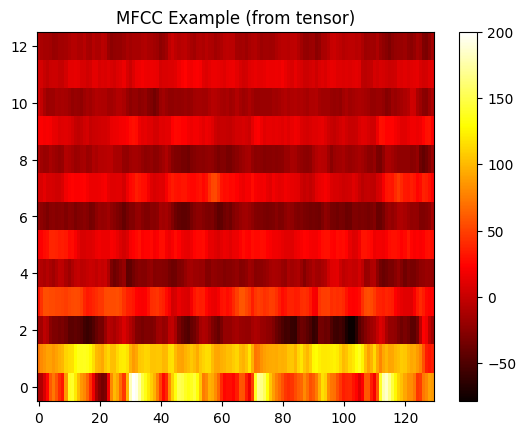

In [91]:
# Visualise data
mfcc_example = inputs[0].numpy()
plt.imshow(mfcc_example.T, cmap='hot', aspect='auto', origin='lower') # .T is used because mfcc tensor is transposed in preprocess.py in line 70
plt.colorbar()
plt.title("MFCC Example (from tensor)")
plt.show()

### 3. Create DataSets and DataLoaders

In order to use the data in our model, we have to organize it into PyTorch DataLoaders. First we use the `train_test_split` method that we imported from sklearn, in order to create train and test datasets. We divide our initial data into 70% for training and 30% for testing.
We use a batch size of 32 for the DataLoaders.

In [92]:
# split the data into train and test sets
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)
print(f"Train set: {len(inputs_train)} samples, {len(targets_train)} labels")
print(f"Test set: {len(inputs_test)} samples, {len(targets_test)} labels")

Train set: 6997 samples, 6997 labels
Test set: 2999 samples, 2999 labels


In [93]:
# create train/test datasets and dataloaders
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE=32

train_dataset = TensorDataset(inputs_train, targets_train)
test_dataset = TensorDataset(inputs_test, targets_test)

train_dataloader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_dataloader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002024480CB90>, <torch.utils.data.dataloader.DataLoader object at 0x00000202448CB610>)
Length of train dataloader: 219 batches of 32
Length of test dataloader: 94 batches of 32


### 4. Building a basic MLP model

The architecture of the model is based on a basic multi layer neural network. It consists of `nn.Linear()` layers and we use the `ReLu()` activation for each. First, we use an `nn.flatten()` layer because such architectures need to have vectors as in features. Those vectors have initially the tensor dimensions compressed. So in our case we input the `num_features` where `num_features = input_shape[0] * input_shape[1]`. Those two values will actually be the _time_frames * mfcc_coefficients_ which is actually 130 * 13 = 1690.

This model will output logits. We can apply an `nn.Softmax()` function to those logits in order to get probabilities. However it is good practise to do this later. Furthermore we are going to use `nn.CrossEntropyLoss` later and this method takes logits as arguments.

Futhermore, we use `summary()` from the torchinfo library to have a detailed perspective of the model.

In [94]:
# build the network architecture

NUM_CLASSES = 10
INPUT_SHAPE = (inputs.shape[1], inputs.shape[2])

class MLPClassifierV0(nn.Module):
    def __init__(self, input_shape, num_classes=10):
        super().__init__()

        num_features = input_shape[0] * input_shape[1]  # f

        self.flatten = nn.Flatten()
        self.layer_1 = nn.Linear(num_features, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 64)
        self.output = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# create a model and put it to device
modelMPL_0 = MLPClassifierV0(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES).to(device)
print(modelMPL_0)
print(next(modelMPL_0.parameters()).device)

MLPClassifierV0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=1690, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)
cuda:0


In [95]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
logits = modelMPL_0(inputs_train.to(device))
probs = torch.softmax(logits, dim=1)
print(logits[:5])
print(probs[:5])

tensor([[ 0.4038, -3.1534,  2.3214, -0.7207, -1.2010, -0.1652, -0.1961,  1.2575,
          1.6471,  4.2178],
        [-1.0353, -1.1886,  1.5786,  0.0771,  1.2181,  0.1259,  0.7406,  0.8312,
          0.8658,  2.2622],
        [ 0.4741, -1.5240,  1.1084, -1.1021, -0.4252,  0.1554,  1.4473,  0.5978,
          1.1053,  2.8745],
        [ 0.7450, -3.2905,  2.4823, -1.7129, -1.6641,  1.1326,  0.0603,  2.0454,
          1.8890,  4.2684],
        [-0.8549, -5.4276,  2.8166, -1.7742,  2.4390,  1.1086, -3.3871,  0.9691,
          4.0593,  6.1286]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[1.6495e-02, 4.7045e-04, 1.1225e-01, 5.3580e-03, 3.3145e-03, 9.3381e-03,
         9.0540e-03, 3.8739e-02, 5.7191e-02, 7.4779e-01],
        [1.2924e-02, 1.1087e-02, 1.7645e-01, 3.9312e-02, 1.2304e-01, 4.1275e-02,
         7.6327e-02, 8.3558e-02, 8.6503e-02, 3.4952e-01],
        [4.7513e-02, 6.4422e-03, 8.9594e-02, 9.8232e-03, 1.9330e-02, 3.4546e-02,
         1.2573e-01, 5.3768e-02, 8.9316e-02, 5.2394e

In [96]:
# Have a summary of the model
from torchinfo import summary

summary(modelMPL_0, input_size=(32, inputs.shape[1], inputs.shape[2]))


Layer (type:depth-idx)                   Output Shape              Param #
MLPClassifierV0                          [32, 10]                  --
├─Flatten: 1-1                           [32, 1690]                --
├─Linear: 1-2                            [32, 512]                 865,792
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 256]                 131,328
├─ReLU: 1-5                              [32, 256]                 --
├─Linear: 1-6                            [32, 64]                  16,448
├─ReLU: 1-7                              [32, 64]                  --
├─Linear: 1-8                            [32, 10]                  650
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 32.45
Input size (MB): 0.22
Forward/backward pass size (MB): 0.22
Params size (MB): 4.06
Estimated Total Size (MB): 4.49

### 5. Training the model

We start by setting a loss function and an optimizer. Two crucial elements of the training procedure.
A helper function named `accuracy_fn()` is going to help us calculate the accuracy. We could use `torchmetrics.accuracy()`, but instead one can implement it.
The training pipeling includes defining a dictionary for the results. This will help later on with the plots that will give us a view on how the model performs. The training also involves batching, so loss and accuracy is calculated for each batch and the result is accumulated.

In [97]:
# create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelMPL_0.parameters(),
                            lr=0.0001)

In [98]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [99]:
# train the model
EPOCHS = 100

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the number of epochs
epochs = EPOCHS

# Create empty results dictionary
results_0 = {"train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    # print(f"Epoch: {epoch + 1}\n-------")
    ### Training
    train_loss, train_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device)
        modelMPL_0.train()

        # 1. Forward pass
        y_pred = modelMPL_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        #  Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # argmax() is going to give us the index of the largest logit. Hence the label

        # # Print out how many samples have been seen
        # if batch % 100 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    # Divide total train accuracy by length of train dataloader (per batch)
    train_acc /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    modelMPL_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:

            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = modelMPL_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    # 5. Update results dictionary
    results_0["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results_0["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results_0["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results_0["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 2.00586, Train acc: 28.83% | Test loss: 1.76593, Test acc: 36.31%
Epoch: 2 | Train loss: 1.71434, Train acc: 38.36% | Test loss: 1.65604, Test acc: 40.01%
Epoch: 3 | Train loss: 1.61444, Train acc: 41.51% | Test loss: 1.59188, Test acc: 41.82%
Epoch: 4 | Train loss: 1.54217, Train acc: 43.80% | Test loss: 1.54017, Test acc: 44.16%
Epoch: 5 | Train loss: 1.48926, Train acc: 46.12% | Test loss: 1.51203, Test acc: 45.82%
Epoch: 6 | Train loss: 1.44464, Train acc: 47.28% | Test loss: 1.48377, Test acc: 45.57%
Epoch: 7 | Train loss: 1.40983, Train acc: 48.67% | Test loss: 1.45419, Test acc: 47.64%
Epoch: 8 | Train loss: 1.37843, Train acc: 49.99% | Test loss: 1.43106, Test acc: 48.03%
Epoch: 9 | Train loss: 1.34867, Train acc: 51.07% | Test loss: 1.42281, Test acc: 47.74%
Epoch: 10 | Train loss: 1.32423, Train acc: 52.22% | Test loss: 1.41329, Test acc: 48.27%
Epoch: 11 | Train loss: 1.30067, Train acc: 52.77% | Test loss: 1.38929, Test acc: 49.85%
Epoch: 12 | Train l

### 6. Plotting the results

We define a helper method to plot the results. We then use matplotlib to plot how our model performed.

In [100]:
_# method to plot loss and accuracy
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

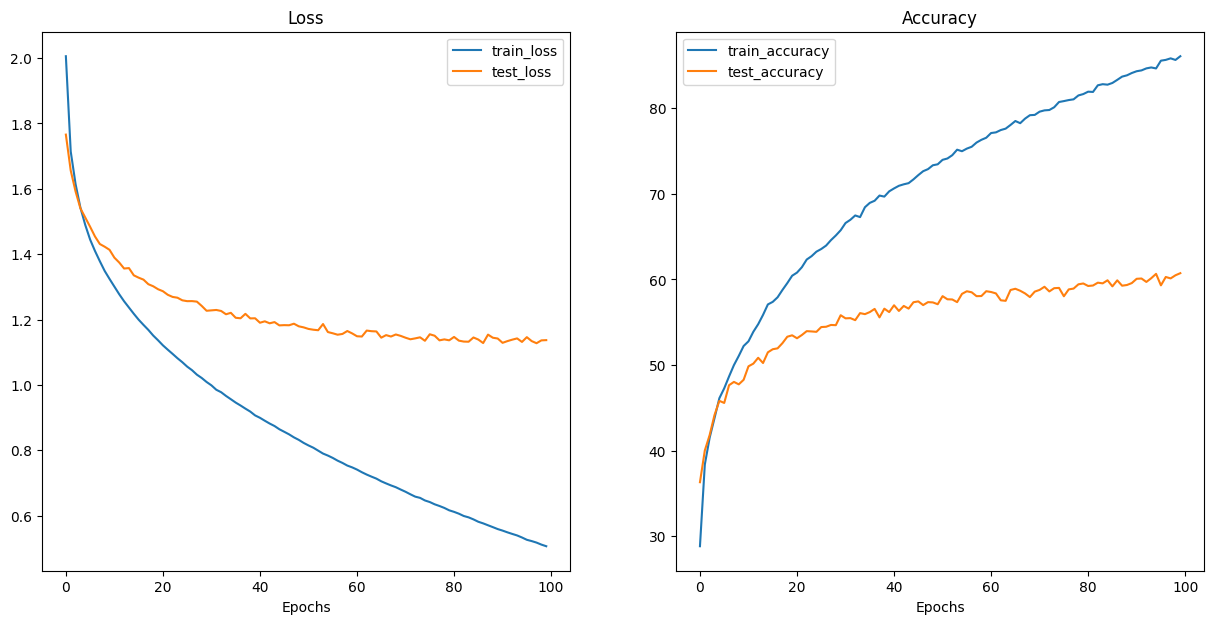

In [101]:
plot_loss_curves(results_0)

Judging by the plot results. We see that our model is overfitting. Somewhere after the 8 epochs, the model starts going well on the train test, but not so well on the test set. As a result we will try to make a new model to avoid this.

### 7. Implementing methods to avoid overfitting

As we saw on the plots, our first model is overfitting. There are several methods to avoid that. We are going to create a second version of our model. It is going to be the same as the first with 2 differences. We are going to apply dropout and regularization. In order to do that, a `nn.Dropout()` layer is added in the model. We are also going to add an L2 regularization. This is added in the optimizer with the form of the `weight_decay` argument.

After instatiating the new model, we follow the same training and plotting pipelines.

In [102]:
# build the network architecture

NUM_CLASSES = 10
INPUT_SHAPE = (inputs.shape[1], inputs.shape[2])

class MLPClassifierV1(nn.Module):
    def __init__(self, input_shape, num_classes=10):
        super().__init__()

        num_features = input_shape[0] * input_shape[1]  # f

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.output = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # 30% dropout


    def forward(self, x):
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.output(x)
        return x

# create a model and put it to device
modelMPL_1 = MLPClassifierV1(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES).to(device)
print(modelMPL_1)

MLPClassifierV1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1690, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [103]:
# create loss and optimizer with L2 Regularization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelMPL_1.parameters(),
                            lr=0.0001,
                            weight_decay=0.001) # added regularization

In [104]:
# train the model

EPOCHS = 100

# Set the number of epochs
epochs = EPOCHS

# Create empty results dictionary
results_1 = {"train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    # print(f"Epoch: {epoch + 1}\n-------")
    ### Training
    train_loss, train_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device)

        modelMPL_1.train()
        # 1. Forward pass
        y_pred = modelMPL_1(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        #  Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # # Print out how many samples have been seen
        # if batch % 100 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    # Divide total train accuracy by length of train dataloader (per batch)
    train_acc /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    modelMPL_1.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:

            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = modelMPL_1(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

    # 5. Update results dictionary
    results_1["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results_1["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results_1["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results_1["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 3.01910, Train acc: 15.81% | Test loss: 1.99172, Test acc: 31.37%
Epoch: 2 | Train loss: 2.36201, Train acc: 21.16% | Test loss: 1.91222, Test acc: 32.76%
Epoch: 3 | Train loss: 2.19520, Train acc: 24.00% | Test loss: 1.87022, Test acc: 34.58%
Epoch: 4 | Train loss: 2.12079, Train acc: 25.74% | Test loss: 1.83817, Test acc: 35.48%
Epoch: 5 | Train loss: 2.05209, Train acc: 27.70% | Test loss: 1.80913, Test acc: 36.56%
Epoch: 6 | Train loss: 2.01363, Train acc: 28.59% | Test loss: 1.78204, Test acc: 37.82%
Epoch: 7 | Train loss: 1.97682, Train acc: 29.43% | Test loss: 1.75550, Test acc: 37.96%
Epoch: 8 | Train loss: 1.95152, Train acc: 30.04% | Test loss: 1.73713, Test acc: 38.94%
Epoch: 9 | Train loss: 1.92136, Train acc: 30.85% | Test loss: 1.71362, Test acc: 39.17%
Epoch: 10 | Train loss: 1.89538, Train acc: 31.79% | Test loss: 1.69640, Test acc: 39.77%
Epoch: 11 | Train loss: 1.88295, Train acc: 32.37% | Test loss: 1.67995, Test acc: 40.70%
Epoch: 12 | Train l

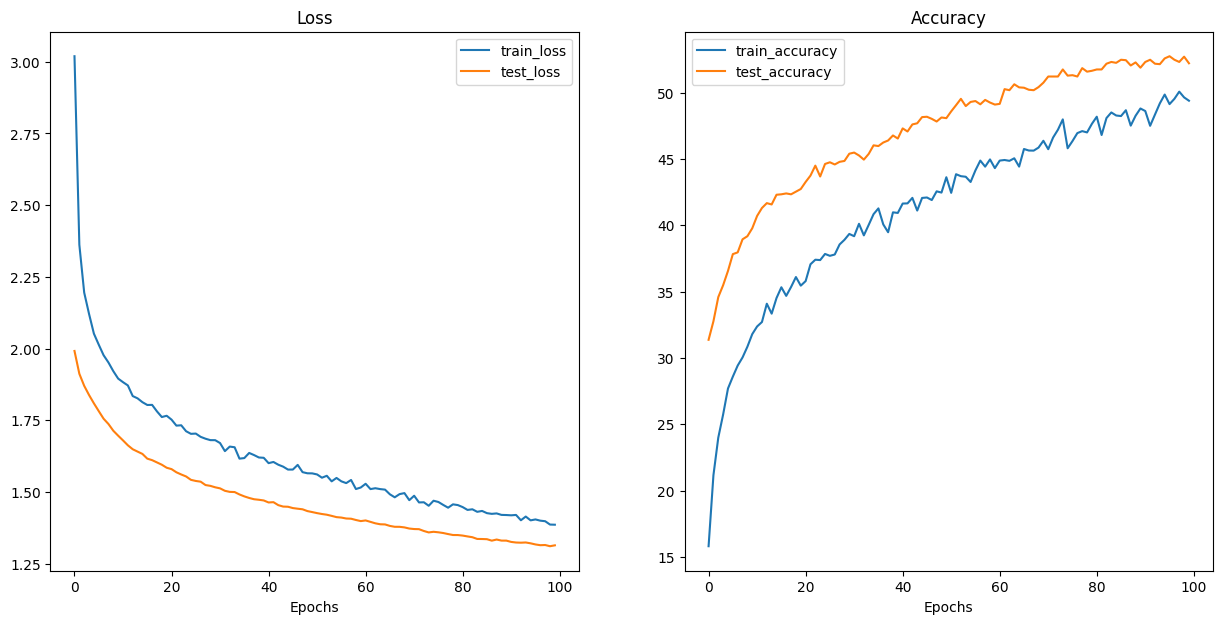

In [105]:
plot_loss_curves(results_1)

It is obvious that the overfitting issue is fixed. However, the model doesn't perform that well. This may be due to a variety of reasons. One is the fact that we used a simple MLP. Other model architectures are tested to perform better on such classification issues.